Show a handful of example spectra in both galaxies.

Then make a second plot that shows the fits of both models in a smaller set.


M31 15A BC taper:

y     x

 959  1024
 
 887   980
 
1156   949

1140   948  # multiple distinct <3 km/s components


M33 14B:

y     x

 459   953
 
 651   733
 
 835   445
 
 912   441
 
1177   768

In [1]:
%matplotlib inline

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import Projection
from scipy import ndimage as nd
from astropy.stats import histogram as astro_hist
from tqdm import tqdm
from corner import hist2d

from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
# from radio_beam import Beam
from astropy.wcs.utils import proj_plane_pixel_area

osjoin = os.path.join

repo_path = os.path.expanduser("~/ownCloud/project_code/ThickHIFitting/")

figures_path_png = osjoin(repo_path, "figures/png")
figures_path_pdf = osjoin(repo_path, "figures/pdf")


def save_figure(fig, plot_name):
    fig.savefig(f"{figures_path_pdf}/{plot_name}.pdf")
    fig.savefig(f"{figures_path_png}/{plot_name}.png")


paths_script = os.path.join(repo_path, "paths.py")
exec(compile(open(paths_script, "rb").read(), paths_script, 'exec'))

plotstyle_script = os.path.join(repo_path, "plotting_styles.py")
exec(compile(open(plotstyle_script, "rb").read(), plotstyle_script, 'exec'))

model_script = os.path.join(repo_path, "gaussian_model.py")
exec(compile(open(model_script, "rb").read(), model_script, 'exec'))

thickHI_model_script = os.path.join(repo_path, "thickHI_model.py")
exec(compile(open(thickHI_model_script, "rb").read(),
             thickHI_model_script, 'exec'))

In [2]:
# M31

m31_cube_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("M31_15A_B_C_14A_HI_contsub_width_0_4kms.image.pbcor.EBHIS_feathered_K.fits")
m31_cube = SpectralCube.read(m31_cube_name)
print(f'Opening cube {os.path.basename(m31_cube_name)}')

m31_vels = m31_cube.spectral_axis.to(u.m / u.s)
      
# del m31_cube

m31_mom0 = Projection.from_hdu(fits.open(fifteenA_HI_BCtaper_wEBHIS_HI_file_dict['Moment0'])).to(u.K * u.km / u.s)
      
m31_multigauss_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_multigaussian_gausspy_fits_neighbcheck2_nomw.fits")
# m31_multigauss_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_multigaussian_gausspy_fits_neighbcheck2.fits")
m31_multigauss_hdu = fits.open(m31_multigauss_name)

m31_ngauss = np.isfinite(m31_multigauss_hdu[0].data).sum(0) // 3

m31_thickHI_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_5kms_centlimit.fits")
m31_thickHI_hdu = fits.open(m31_thickHI_name)

m31_thickHI80_name = fifteenA_HI_BCtaper_04kms_data_wEBHIS_path("individ_simplethick_HI_fits_80kms_centlimit.fits")
m31_thickHI80_hdu = fits.open(m31_thickHI_name)

# Keep only where the fit parameters are valid
m31_multigauss_hdu[2].data[m31_ngauss == 0] = np.NaN

m31_multigauss_bic_proj = Projection.from_hdu(m31_multigauss_hdu[2])
m31_thickHI_bic_proj = Projection.from_hdu(m31_thickHI_hdu[2])
m31_thickHI80_bic_proj = Projection.from_hdu(m31_thickHI80_hdu[2])

# Slice out to zoom into the valid data region.
spat_slice_zoom_m31 = tuple([slice(vals.min() - 10, vals.max() + 10) for vals in
                             np.where(np.isfinite(m31_multigauss_hdu[2].data))])
print(spat_slice_zoom_m31)
# Make custom slice so the array shapes are roughly the same in M33 and M31
spat_slice_zoom_m31 = (slice(105, 1709), slice(347, 1603))

Opening cube M31_15A_B_C_14A_HI_contsub_width_0_4kms.image.pbcor.EBHIS_feathered_K.fits
(slice(247, 1568, None), slice(338, 1611, None))


In [3]:
# M33

cube_name = fourteenB_HI_data_wGBT_path("M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.fits")

downsamp_cube_name = f"{cube_name.rstrip('.fits')}_0p42kms_K.fits"
        
m33_cube = SpectralCube.read(downsamp_cube_name)
print(f'Opening cube {downsamp_cube_name}')

m33_vels = m33_cube.spectral_axis.to(u.m / u.s)
      
# del m33_cube

m33_mom0_name = "M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked.moment0_Kkms.fits"
m33_mom0 = Projection.from_hdu(fits.open(fourteenB_HI_data_wGBT_path(m33_mom0_name))).to(u.K * u.km / u.s)

m33_multigauss_name = fourteenB_HI_data_wGBT_path("individ_multigaussian_gausspy_fits_neighbcheck2_nomw.fits")
# m33_multigauss_name = fourteenB_HI_data_wGBT_path("individ_multigaussian_gausspy_fits_neighbcheck2.fits")
m33_multigauss_hdu = fits.open(m33_multigauss_name)

m33_ngauss = np.isfinite(m33_multigauss_hdu[0].data).sum(0) // 3

m33_thickHI_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_5kms_centlimit.fits")
m33_thickHI_hdu = fits.open(m33_thickHI_name)

m33_thickHI80_name = fourteenB_HI_data_wGBT_path("individ_simplethick_HI_fits_80kms_centlimit.fits")
m33_thickHI80_hdu = fits.open(m33_thickHI_name)

# Keep only where the fit parameters are valid
m33_multigauss_hdu[2].data[m33_ngauss == 0] = np.NaN

m33_multigauss_bic_proj = Projection.from_hdu(m33_multigauss_hdu[2])
m33_thickHI_bic_proj = Projection.from_hdu(m33_thickHI_hdu[2])
m33_thickHI80_bic_proj = Projection.from_hdu(m33_thickHI80_hdu[2])

# Slice out to zoom into the valid data region.
spat_slice_zoom_m33 = (slice(None), slice(None))


Opening cube /mnt/bigdata/ekoch/M33/VLA/14B-088/HI/full_imaging_wGBT/M33_14B-088_HI.clean.image.GBT_feathered.pbcov_gt_0.5_masked_0p42kms_K.fits


In [4]:
m31_pix = [ [959,  1024],
            [887,   980],
            [1156,   949],
            [1140,  948]]
m31_pix = np.array(m31_pix)

m33_pix = [ [459,  953],
            [651,   733],
#             [835,   445],
            [912,   441],
            [1177,  768]]

m33_pix = np.array(m33_pix)

In [5]:
m31_noise = 2.8
m33_noise = 2.4 / np.sqrt(2)

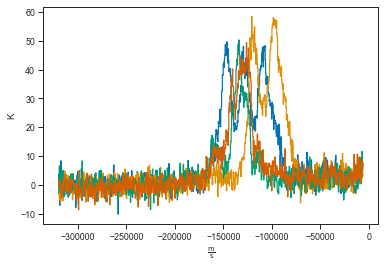

In [6]:
for y, x in m31_pix:
    m31_cube[:, y, x].quicklook()

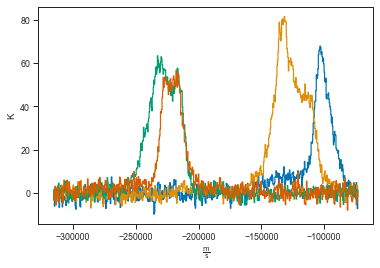

In [7]:
for y, x in m33_pix:
    m33_cube[:, y, x].quicklook()

Just the example spectrum plotted.

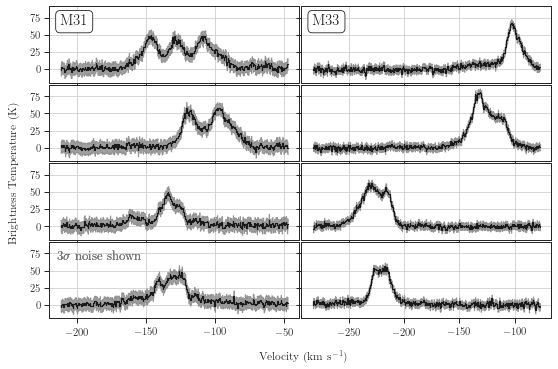

In [8]:
twocolumn_figure(font_scale=1.2)

fig, axs = plt.subplots(4, 2, sharey=True)

m31_specslice = slice(100, 500)

for i, (y, x) in enumerate(m31_pix):
    
    axs[i, 0].fill_between(m31_vels.to(u.km / u.s).value[m31_specslice],
                   m31_cube[:, y, x].value[m31_specslice] - 3 * m31_noise,
                   m31_cube[:, y, x].value[m31_specslice] + 3 * m31_noise,
                   step='mid', color='gray', alpha=0.75)

    axs[i, 0].plot(m31_vels.to(u.km / u.s).value[m31_specslice],
                   m31_cube[:, y, x].value[m31_specslice],
                   drawstyle='steps-mid', color='k')
    
    axs[i, 0].grid(True)
        
    if i != 3:
        axs[i, 0].set_xticklabels([])
    
m33_specslice = slice(10, 510)
    
for i, (y, x) in enumerate(m33_pix):
    
    axs[i, 1].fill_between(m33_vels.to(u.km / u.s).value[m33_specslice],
                   m33_cube[:, y, x].value[m33_specslice] - 3 * m33_noise,
                   m33_cube[:, y, x].value[m33_specslice] + 3 * m33_noise,
                   step='mid', color='gray', alpha=0.75)
    
    axs[i, 1].plot(m33_vels.to(u.km / u.s).value[m33_specslice],
                   m33_cube[:, y, x].value[m33_specslice],
                   drawstyle='steps-mid', color='k')
    
    axs[i, 1].grid(True)
    
    if i != 3:
        axs[i, 1].set_xticklabels([])
        
axs[0, 0].set_yticks([0, 25, 50, 75])

xp = 0.1
yp = 0.8
bbox_props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='k')

axs[0, 0].text(xp, yp, "M31", transform=axs[0, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)
axs[0, 1].text(xp, yp, "M33", transform=axs[0, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=bbox_props, fontsize=15)

# Add a label for the noise levels
axs[3, 0].text(xp + 0.1, yp, r"$3\sigma$ noise shown",
               transform=axs[3, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=None, fontsize=13,
               weight='bold',
               color='k',
               alpha=1.)

axs[3, 0].text(xp + 0.1, yp, r"$3\sigma$ noise shown",
               transform=axs[3, 0].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=None, fontsize=13,
               color='gray',
               alpha=1.)


fig.text(0.06, 0.5, "Brightness Temperature (K)",
         ha='center', va='center', rotation='vertical')

fig.text(0.54, 0.06, r"Velocity (km s$^{-1}$)",
         ha='center', va='center', rotation='horizontal')

fig.subplots_adjust(top=0.9, bottom=0.15, right=0.95, left=0.12, wspace=0.01, hspace=0.03)

save_figure(fig, 'm31_m33_example_hi_spectra')


Show fits for a sub-set of these.

I think 4 spectra (2 from each), with 2 panels, one with each fit shown. Same setup as above but read across.

Residual sub-sub plots made following https://stackoverflow.com/questions/44379168/python-add-residuals-to-subplots-generated-by-a-for-loop

248.2231870670453 34.11982916160245 7.275041908661989
39.54490347300573 7999.916326127859 0.004943164635841431
132.8051993663949 78.51387470932849 1.6914870124301213
148.75392459772382 57.63801297149162 2.58083020091791


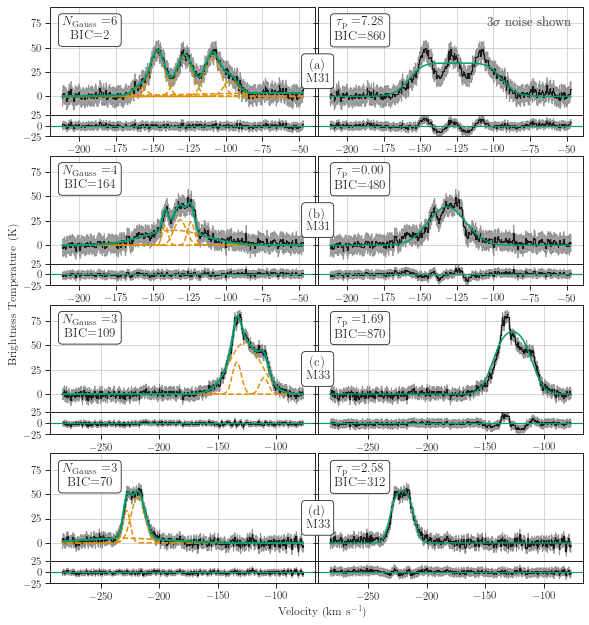

In [13]:
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable

def create_resid_ax(ax, size="20%", pad=0):
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size=size, pad=pad)
    ax.figure.add_axes(ax2)
    ax.set_xticklabels([])
    return ax2    
    
    
twocolumn_figure(font_scale=1.2)

fig, axs = plt.subplots(4, 2, sharey=True, figsize=(8.6, 10))

m31_specslice = slice(100, 500)

j = 0
for i, (y, x) in enumerate(m31_pix):
    
    # Keeping the first and last one
    if i == 1 or i == 2:
        continue
    
    axs[j, 0].fill_between(m31_vels.to(u.km / u.s).value[m31_specslice],
                   m31_cube[:, y, x].value[m31_specslice] - 3 * m31_noise,
                   m31_cube[:, y, x].value[m31_specslice] + 3 * m31_noise,
                   step='mid', color='gray', alpha=0.75)

    axs[j, 0].plot(m31_vels.to(u.km / u.s).value[m31_specslice],
                   m31_cube[:, y, x].value[m31_specslice],
                   drawstyle='steps-mid', color='k')
    
    axs[j, 0].grid(True)
    
    # MultiGauss model eval
    vels_eval = m31_vels.to(u.km / u.s).value[m31_specslice]
    
    mg_params = m31_multigauss_hdu[0].data[:, y, x]
    mg_params = mg_params[np.isfinite(mg_params)]
    spec_model = multigaussian_nolmfit(vels_eval * 1000., mg_params)

    # For each component
    ncmp = mg_params.size // 3
    for i in range(ncmp):
        spec_model_i = multigaussian_nolmfit(vels_eval * 1000.,
                                             mg_params[3 * i:3 * i + 3])

        axs[j, 0].plot(vels_eval,
                       spec_model_i,
                       color=sb.color_palette()[1], linestyle='--',
                       linewidth=1.5)
        
    axs[j, 0].plot(vels_eval,
                   spec_model,
                   color=sb.color_palette()[2], linewidth=2)
        
    # Display # of Gauss and BIC
    bic_fitval = m31_multigauss_hdu[2].data[y, x]
    axs[j, 0].text(0.15, 0.9,
                   r"$N_{\rm Gauss}=$" + f"{ncmp}\n" + f"BIC={bic_fitval:.0f}",
                   transform=axs[j, 0].transAxes,
                   horizontalalignment='center',
                   verticalalignment='top',
                   bbox=bbox_props, fontsize=13)
    
    # Make a residual subsubpot
    ax2 = create_resid_ax(axs[j, 0])
    
    mod_resid = m31_cube[:, y, x].value[m31_specslice] - spec_model
    
    ax2.fill_between(vels_eval,
                   mod_resid - 3 * m31_noise,
                   mod_resid + 3 * m31_noise,
                   step='mid', color='gray', alpha=0.75)

    ax2.plot(vels_eval,
             mod_resid,
             drawstyle='steps-mid', color='k')
    
    ax2.grid(True)

    ax2.axhline(0., color=sb.color_palette()[2])
    
    ax2.set_ylim([-25, 25])

#     if j != 1:
#         ax2.set_xticklabels([])
        
    # Opaque model
    
    axs[j, 1].fill_between(m31_vels.to(u.km / u.s).value[m31_specslice],
                   m31_cube[:, y, x].value[m31_specslice] - 3 * m31_noise,
                   m31_cube[:, y, x].value[m31_specslice] + 3 * m31_noise,
                   step='mid', color='gray', alpha=0.75)

    axs[j, 1].plot(m31_vels.to(u.km / u.s).value[m31_specslice],
                   m31_cube[:, y, x].value[m31_specslice],
                   drawstyle='steps-mid', color='k')
    
    # Opaque model eval
    params_thickHI = m31_thickHI_hdu[0].data[:, y, x]
    mod_thickHI = isoturbHI_simple(vels_eval,
                                   params_thickHI[0],
                                   params_thickHI[1],
                                   params_thickHI[2],
                                   params_thickHI[3])
    axs[j, 1].plot(vels_eval,
                   mod_thickHI,
                   color=sb.color_palette()[2], linewidth=1.5) 

    axs[j, 1].grid(True)
    
    # Make a residual subsubpot
    ax2 = create_resid_ax(axs[j, 1])
    
    mod_resid = m31_cube[:, y, x].value[m31_specslice] - mod_thickHI
    
    ax2.fill_between(vels_eval,
                   mod_resid - 3 * m31_noise,
                   mod_resid + 3 * m31_noise,
                   step='mid', color='gray', alpha=0.75)

    ax2.plot(vels_eval,
             mod_resid,
             drawstyle='steps-mid', color='k')
    
    ax2.grid(True)
    
    ax2.axhline(0., color=sb.color_palette()[2])
    
    ax2.set_ylim([-25, 25])

    ax2.set_yticklabels([])
    
#     if j != 1:
#         ax2.set_xticklabels([])
        
    # Show the inferred peak tau
    infpeaktau = params_thickHI[2] / params_thickHI[0]
    print(params_thickHI[2], params_thickHI[0], infpeaktau)
    bic_fitval_th = m31_thickHI_hdu[2].data[y, x]
    axs[j, 1].text(0.16, 0.9,
                   r"$\tau_{\rm p}=$" + f"{infpeaktau:.2f}\n" + f"BIC={bic_fitval_th:.0f}",
                   transform=axs[j, 1].transAxes,
                   horizontalalignment='center',
                   verticalalignment='top',
                   bbox=bbox_props, fontsize=13)
    
    # Make a label with the galaxy included
    axs[j, 1].text(0.0, 0.4,
                   f"({string.ascii_lowercase[j]})\nM31",
                   transform=axs[j, 1].transAxes,
                   horizontalalignment='center',
                   verticalalignment='center',
                   bbox=bbox_props, fontsize=13)
    
    j += 1
    

# And now the M33 fit examples
for i, (y, x) in enumerate(m33_pix):
    
    # Keeping the first and last one
    if i == 0 or i == 2:
        continue
    
    axs[j, 0].fill_between(m33_vels.to(u.km / u.s).value[m33_specslice],
                   m33_cube[:, y, x].value[m33_specslice] - 3 * m33_noise,
                   m33_cube[:, y, x].value[m33_specslice] + 3 * m33_noise,
                   step='mid', color='gray', alpha=0.75)

    axs[j, 0].plot(m33_vels.to(u.km / u.s).value[m33_specslice],
                   m33_cube[:, y, x].value[m33_specslice],
                   drawstyle='steps-mid', color='k')
    
    axs[j, 0].grid(True)
    
    # MultiGauss model eval
    vels_eval = m33_vels.to(u.km / u.s).value[m33_specslice]
    
    mg_params = m33_multigauss_hdu[0].data[:, y, x]
    mg_params = mg_params[np.isfinite(mg_params)]
    spec_model = multigaussian_nolmfit(vels_eval * 1000., mg_params)

    # For each component
    ncmp = mg_params.size // 3
    for i in range(ncmp):
        spec_model_i = multigaussian_nolmfit(vels_eval * 1000.,
                                             mg_params[3 * i:3 * i + 3])

        axs[j, 0].plot(vels_eval,
                       spec_model_i,
                       color=sb.color_palette()[1], linestyle='--',
                       linewidth=1.5)
        
    axs[j, 0].plot(vels_eval,
                   spec_model,
                   color=sb.color_palette()[2], linewidth=2)
        
    # Display # of Gauss and BIC
    bic_fitval = m33_multigauss_hdu[2].data[y, x]
    axs[j, 0].text(0.15, 0.9,
                   r"$N_{\rm Gauss}=$" + f"{ncmp}\n" + f"BIC={bic_fitval:.0f}",
                   transform=axs[j, 0].transAxes,
                   horizontalalignment='center',
                   verticalalignment='top',
                   bbox=bbox_props, fontsize=13)
    
    # Make a residual subsubpot
    ax2 = create_resid_ax(axs[j, 0])
    
    mod_resid = m33_cube[:, y, x].value[m33_specslice] - spec_model
    
    ax2.fill_between(vels_eval,
                   mod_resid - 3 * m33_noise,
                   mod_resid + 3 * m33_noise,
                   step='mid', color='gray', alpha=0.75)

    ax2.plot(vels_eval,
             mod_resid,
             drawstyle='steps-mid', color='k')
    
    ax2.grid(True)

    ax2.axhline(0., color=sb.color_palette()[2])
    
    ax2.set_ylim([-25, 25])

#     if j != 3:
#         ax2.set_xticklabels([])
        
    # Opaque model
    
    axs[j, 1].fill_between(m33_vels.to(u.km / u.s).value[m33_specslice],
                   m33_cube[:, y, x].value[m33_specslice] - 3 * m33_noise,
                   m33_cube[:, y, x].value[m33_specslice] + 3 * m33_noise,
                   step='mid', color='gray', alpha=0.75)

    axs[j, 1].plot(m33_vels.to(u.km / u.s).value[m33_specslice],
                   m33_cube[:, y, x].value[m33_specslice],
                   drawstyle='steps-mid', color='k')
    
    # Opaque model eval
    params_thickHI = m33_thickHI_hdu[0].data[:, y, x]
    mod_thickHI = isoturbHI_simple(vels_eval,
                                   params_thickHI[0],
                                   params_thickHI[1],
                                   params_thickHI[2],
                                   params_thickHI[3])
    axs[j, 1].plot(vels_eval,
                   mod_thickHI,
                   color=sb.color_palette()[2], linewidth=1.5) 

    axs[j, 1].grid(True)
    
    # Make a residual subsubpot
    ax2 = create_resid_ax(axs[j, 1])
    
    mod_resid = m33_cube[:, y, x].value[m33_specslice] - mod_thickHI
    
    ax2.fill_between(vels_eval,
                   mod_resid - 3 * m31_noise,
                   mod_resid + 3 * m31_noise,
                   step='mid', color='gray', alpha=0.75)

    ax2.plot(vels_eval,
             mod_resid,
             drawstyle='steps-mid', color='k')
    
    ax2.grid(True)
    
    ax2.axhline(0., color=sb.color_palette()[2])
    
    ax2.set_ylim([-25, 25])

    ax2.set_yticklabels([])
    
#     if j != 3:
#         ax2.set_xticklabels([])
        
    # Show the inferred peak tau
    infpeaktau = params_thickHI[2] / params_thickHI[0]
    print(params_thickHI[2], params_thickHI[0], infpeaktau)
    bic_fitval_th = m33_thickHI_hdu[2].data[y, x]
    axs[j, 1].text(0.16, 0.9,
                   r"$\tau_{\rm p}=$" + f"{infpeaktau:.2f}\n" + f"BIC={bic_fitval_th:.0f}",
                   transform=axs[j, 1].transAxes,
                   horizontalalignment='center',
                   verticalalignment='top',
                   bbox=bbox_props, fontsize=13)
    
    # Make a label with the galaxy included
    axs[j, 1].text(0.0, 0.4,
                   f"({string.ascii_lowercase[j]})\nM33",
                   transform=axs[j, 1].transAxes,
                   horizontalalignment='center',
                   verticalalignment='center',
                   bbox=bbox_props, fontsize=13)
    
    j += 1


axs[0, 1].text(0.8, 0.85, r"$3\sigma$ noise shown",
               transform=axs[0, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=None, fontsize=13,
               weight='bold',
               color='k',
               alpha=1.)

axs[0, 1].text(0.8, 0.85, r"$3\sigma$ noise shown",
               transform=axs[0, 1].transAxes,
               horizontalalignment='center',
               verticalalignment='center',
               bbox=None, fontsize=13,
               color='gray',
               alpha=1.)
    
fig.text(0.06, 0.5, "Brightness Temperature (K)",
         ha='center', va='center', rotation='vertical')

fig.text(0.56, 0.06, r"Velocity (km s$^{-1}$)",
         ha='center', va='center', rotation='horizontal')

fig.subplots_adjust(top=0.9, bottom=0.1, right=0.98, left=0.12, wspace=0.01, hspace=0.15)

save_figure(fig, 'm31_m33_example_hi_spectra_wfits')
